In [1]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import exposure, feature
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import sklearn.svm as svm
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob
import joblib


# from sklearn.externals import joblib
from scipy.ndimage.measurements import label
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm 
%matplotlib inline

In [2]:
all_files = []

hands = []
nothands = []

types = ('images/hands/*.jpg', 'images/not-hands/*.jpg')

for files in types:
    all_files.extend(glob.glob(files))

for image_path in all_files:
    if 'not-hands' in image_path:
        nothands.append(image_path)
    else:
        hands.append(image_path)

In [3]:
nothands[1]

'images/not-hands\\002.jpg'

In [4]:
index = 3
tst = hands[index]
img = mpimg.imread(tst)

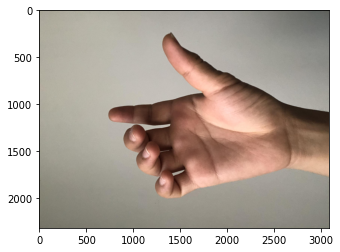

In [5]:
plt.imshow(img)

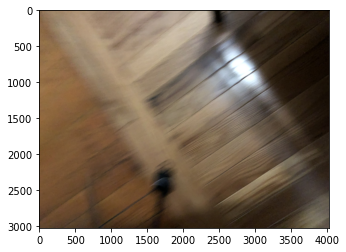

In [6]:
index = 3
tst = nothands[index]
imgnh = mpimg.imread(tst)
plt.imshow(imgnh)

In [7]:
img.shape

(2320, 3088, 3)

In [8]:
def resize_images(img, dimx, dimy):
    image_resized = resize(img, (dimx, dimy), anti_aliasing=True)
    return image_resized

In [9]:
resized_32 = resize_images(img, 32, 32)
resized_64 = resize_images(img, 64, 64)

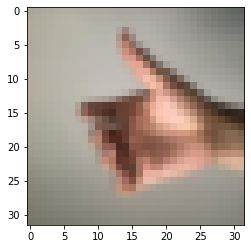

In [10]:
plt.imshow(resized_32)

In [11]:
resized_32.shape

(32, 32, 3)

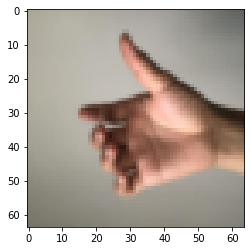

In [12]:
plt.imshow(resized_64)

In [19]:
resized_64[0, 0, :], resized_64[32, 32, :]

(array([0.65490196, 0.64313725, 0.58823529]),
 array([0.62297794, 0.39460784, 0.33094363]))

In [14]:
from skimage.color import rgb2gray

In [15]:
grayscale_64 = rgb2gray(resized_64)

In [16]:
grayscale_64

array([[0.64167882, 0.64588314, 0.6427949 , ..., 0.38797529, 0.38179882,
        0.37367294],
       [0.65040575, 0.65455961, 0.65427686, ..., 0.40340975, 0.39738093,
        0.38964196],
       [0.65484235, 0.65876392, 0.66492549, ..., 0.41514353, 0.40841647,
        0.40459907],
       ...,
       [0.46465765, 0.46494039, 0.46886196, ..., 0.51816784, 0.5131302 ,
        0.50920863],
       [0.45709725, 0.46073608, 0.46101882, ..., 0.51032471, 0.5055698 ,
        0.50500431],
       [0.44820206, 0.45317569, 0.45709725, ..., 0.50528706, 0.50024941,
        0.49913333]])

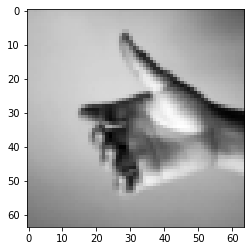

In [17]:
plt.imshow(grayscale_64, cmap=plt.cm.gray)

In [18]:
grayscale_64.shape

(64, 64)

In [19]:
grayscale_64.ravel()

array([0.64167882, 0.64588314, 0.6427949 , ..., 0.50528706, 0.50024941,
       0.49913333])

In [20]:
grayscale_64.ravel().shape

(4096,)

In [21]:
resized_64.ravel().shape

(12288,)

In [22]:
def get_hog_features(img):
    fd, hog_image = hog(img, orientations=5, pixels_per_cell=(2, 2),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    return fd, hog_image

In [23]:
fd, hog_image = get_hog_features(resized_64)

In [24]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

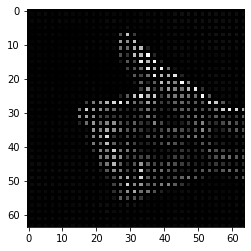

In [25]:
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

In [26]:
hog_image_rescaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00099561, 0.        , ..., 0.00272321, 0.        ,
        0.00216297],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0014782 , 0.        , ..., 0.00168286, 0.        ,
        0.00171295],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00097179, 0.        , ..., 0.00128658, 0.        ,
        0.00117647]])

In [27]:
hog_image_rescaled.shape

(64, 64)

In [28]:
# the hand_features.pkl and nothand_features were pickled so as to collect most descriptive features
# as I had a small data_set I had to work arounnd with such things and the shapes are different here

In [29]:
with open("hand_features.pkl", "rb") as file_obj:
    xf = pickle.load(file_obj)
with open("nothand_features.pkl", "rb") as file_obj:
    yf = pickle.load(file_obj)

In [30]:
x = np.vstack((xf, yf)).astype(np.float64)
y = np.hstack((np.ones(len(xf)), np.zeros(len(yf))))

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
x_scaler = StandardScaler().fit(x_train)

x_train = x_scaler.transform(x_train)
x_valid = x_scaler.transform(x_valid)
x_test = x_scaler.transform(x_test)

linear_svm_clf = svm.LinearSVC()
linear_svm_clf.fit(x_train, y_train)
y_predict = linear_svm_clf.predict(x_test)

In [34]:
print(accuracy_score(y_predict, y_test)); print(linear_svm_clf.score(x_valid, y_valid))

0.625
0.6428571428571429


In [35]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import LeaveOneOut

In [36]:
x, y

(array([[0.99607843, 0.99607843, 0.99607843, ..., 0.25356814, 0.        ,
         0.        ],
        [0.30980392, 0.60392157, 0.27058824, ..., 0.        , 0.        ,
         0.        ],
        [0.99607843, 0.99607843, 0.99607843, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.52506415, 0.48977003, 0.45447591, ..., 0.48238568, 0.        ,
         0.        ],
        [0.68627451, 0.61960784, 0.58823529, ..., 0.07744001, 0.        ,
         0.        ],
        [0.9254902 , 0.92941176, 0.89411765, ..., 0.47371679, 0.        ,
         0.        ]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]))